# Creating Features Through Investigation

On this page, we will focus on creating new features other than the given columns in the dataset. 
Let's start with some simple hypothesis and investigate whether we can use our hypothesis to create a new feature.  

```{note}
This page corresponds to the "Power Feature" part of the original project. I will revise and fix some errors in the original project and add new investigations for more features. 
```

## First Investigation: Relationship Between Location and Fraudulent Posting

The first hypothesis we will investigate is that **location, especially state, is related to whether the posting is fraudulent.** For example, many fake job postings might have come from California or New York since those states have more job availability than others due to their high population. If the location is significantly related to the fraudulent variable, we can extract the state from the location and use it as a feature. Let's investigate the relationship and see if the hypothesis is correct.  

```{note}
This part is not in the original project.
```

In [3]:
import pandas as pd 
import numpy as np
import re
from matplotlib import pyplot as plt

In [4]:
train_data = pd.read_csv("./data/train_set.csv")

To extract the state from the location, let's define the function to make the process easier.

```python
def extract_state(s):
    """ Extract state from the location"""
    """ The function can be used only when the state is formmated with two capital letter"""
    """ Input: Series, iterable object"""
    """ Output: List of States"""
    
    s.fillna("No Location", inplace = True)
    result = []    
    for i in np.arange(len(s)):
        if (s[i].__contains__("US")):
            extracted = re.findall(r'[A-Z]{2}', re.sub(r'[US]','',s[i]))
            # Edge Case 1: Posting is from US but State is not posted
            if extracted == []:
                extracted = ["Domestic"]
            # Edge Case 2: Regex detect a city name as a State name
            if len(extracted) != 1:
                while len(extracted) > 1:
                    extracted.pop()
            result += extracted
        else:
            # Edge Case 3: Location is not given 
            if s[i] == ["No Location"]:
                result += s[i]
            # Edge Case 4: Location is given but not in US
            elif re.findall(r'[A-Z]{2}', s[i]) != []:
                result += ["Foreign"]
            # Edge Case 5: Location cannot be identified from the given information
            else:
                result += ["No Location"]
    return result
```

In [159]:
def extract_state(s):
    """ Extract state from the location"""
    """ The function can be used only when the state is formmated with two capital letter"""
    """ Input: Series, iterable object"""
    """ Output: List of States"""
    
    s.fillna("No Location", inplace = True)
    result = []    
    for i in np.arange(len(s)):
        if (s[i].__contains__("US")):
            extracted = re.findall(r'[A-Z]{2}', re.sub(r'[US]','',s[i]))
            # Edge Case 1: Posting is from US but State is not posted
            if extracted == []:
                extracted = ["Domestic"]
            # Edge Case 2: Regex detect a city name as a State name
            if len(extracted) != 1:
                while len(extracted) > 1:
                    extracted.pop()
            result += extracted
        else:
            # Edge Case 3: Location is not given 
            if s[i] == ["No Location"]:
                result += s[i]
            # Edge Case 4: Location is given but not in US
            elif re.findall(r'[A-Z]{2}', s[i]) != []:
                result += ["Foreign"]
            # Edge Case 5: Location cannot be identified from the given information
            else:
                result += ["No Location"]
    return result

In [168]:
result = extract_state(train_data["location"])
train_data["state"] = result
train_data[["location", "state", "fraudulent"]]

location    state  fraudulent
0      US, VA, Virginia Beach       VA           0
1              US, TX, Dallas       TX           0
2             NZ, , Auckland   Foreign           0
3               US, NE, Omaha       NE           0
4         US, CA, Los Angeles       CA           0
...                       ...      ...         ...
14299          US, CA, Irvine       CA           0
14300           GR, I, Athens  Foreign           0
14301    US, NJ, Elmwood Park       NJ           0
14302         US, AZ, Phoenix       AZ           0
14303         CA, ON, Toronto  Foreign           0

[14304 rows x 3 columns]

Now, let's use the extracted state to validate our hypothesis. 
First of all, let's observe the distribution of state in the entire dataset. 

### Distribution of Location: Entire Dataset

In [301]:
combined_data = train_data["state"].value_counts().to_frame()
combined_data = combined_data.reset_index().rename(columns = {'index':'state', 'state':'count'})
combined_data["percentage"] = (combined_data["count"] / combined_data["count"].sum()) * 100
combined_data.head(10)

state  count  percentage
0      Foreign   5504   38.478747
1           CA   1617   11.304530
2           NY   1003    7.012025
3           TX    806    5.634787
4     Domestic    584    4.082774
5           IL    326    2.279083
6           FL    322    2.251119
7           OH    304    2.125280
8  No Location    280    1.957494
9           MA    262    1.831655

Text(0.5, 1.0, 'Percent Distribution of Location: Entire Dataset')

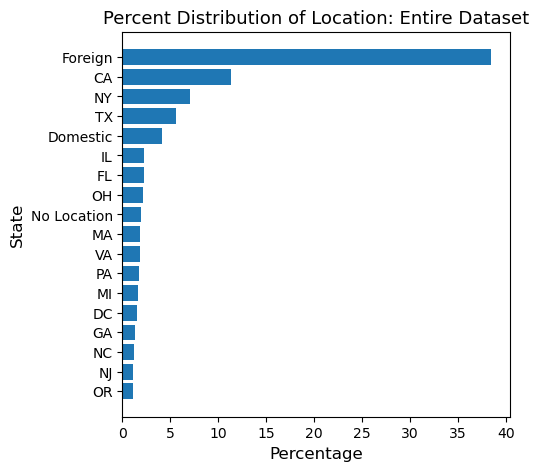

In [294]:
sorted_df = combined_data.sort_values('percentage')
sorted_df = sorted_df[sorted_df['percentage'] > 1]
x = sorted_df['state']
y = sorted_df['percentage']

plt.figure(figsize=(5,5))
plt.barh(x,y)
plt.xlabel("Percentage", size=12)
plt.ylabel("State", size=12)
plt.title("Percent Distribution of Location: Entire Dataset", size=13)

```{note}
Foreign: the job posting has a location outside of the US 

Domestic: the job posting has a US location, but a specific state name is not given

No Location: the job posting did not include a location
```

The distribution of the state of the entire dataset shows that about 40% of job posting is from companies outside the US, and about 20% of job posting is from either California or New York. The result is quite surprising because I was not expecting to see such a high number of 'foreign.'

Let's see if we see a notable difference in distribution when we split the dataset into fraudulent and non-fraudulent.

### Distribution of Location: Fraudulent and Non-Fraudulent Dataset

In [269]:
# Convinent function for data frame display 

from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

In [306]:
fraud_data = train_data[train_data['fraudulent'] == 1]
non_fraud_data = train_data[train_data['fraudulent'] == 0]

f_combined_data = fraud_data["state"].value_counts().to_frame()
f_combined_data = f_combined_data.reset_index().rename(columns = {'index':'state', 'state':'count'})
f_combined_data["percentage"] = (f_combined_data["count"] / f_combined_data["count"].sum()) * 100

nf_combined_data = non_fraud_data["state"].value_counts().to_frame()
nf_combined_data = nf_combined_data.reset_index().rename(columns = {'index':'state', 'state':'count'})
nf_combined_data["percentage"] = (nf_combined_data["count"] / nf_combined_data["count"].sum()) * 100

display_side_by_side([nf_combined_data[0:10], f_combined_data[0:10]], ['Non-Fraudulent', 'Fraudulent'], tablespacing =20)

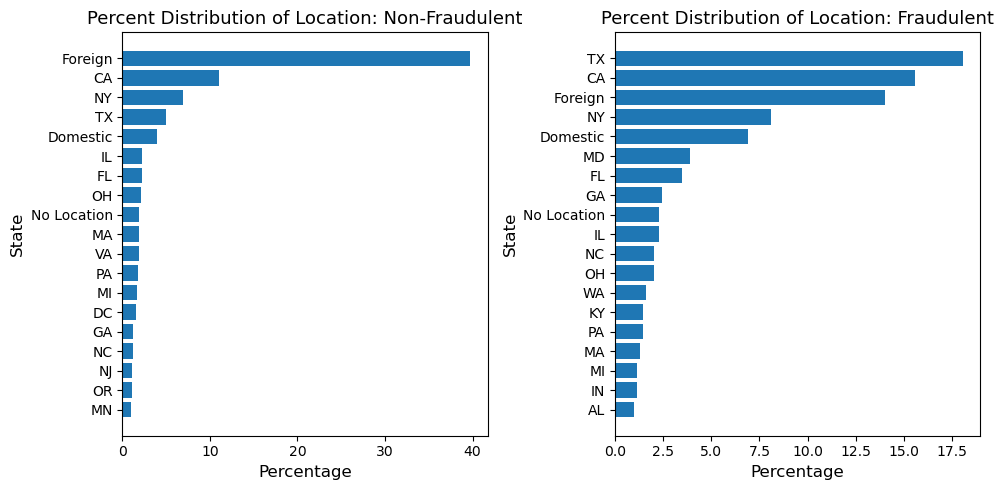

In [298]:
f_sorted_df = f_combined_data.sort_values('percentage')
f_sorted_df = f_sorted_df[f_sorted_df['percentage'] > 1]
x1 = f_sorted_df['state']
y1 = f_sorted_df['percentage']

nf_sorted_df = nf_combined_data.sort_values('percentage')
nf_sorted_df = nf_sorted_df[nf_sorted_df['percentage'] > 1]
x2 = nf_sorted_df['state']
y2 = nf_sorted_df['percentage']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].barh(x2,y2)
axes[0].set_xlabel("Percentage", size=12)
axes[0].set_ylabel("State", size=12)
axes[0].set_title("Percent Distribution of Location: Non-Fraudulent", size=13)

axes[1].barh(x1,y1)
axes[1].set_xlabel("Percentage", size=12)
axes[1].set_ylabel("State", size=12)
axes[1].set_title("Percent Distribution of Location: Fraudulent", size=13)

fig.tight_layout()

The result is fascinating in many ways!

1. **The distributions of fraudulent and non-fraudulent are significantly different.** For example, 40% of non-fraudulent posting comes from foreign countries, while only 14% of fraudulent posting is from the US. Also, Texas shows a notable difference in percentage: 5% in non-fraudulent but 18% in fraudulent.  

2. **We also need to pay close attention to Maryland.** Only 0.4% of non-fraudulent postings are from Maryland, but the percentage jumps to 3.9% in the fraudulent dataset. This is such a huge jump. 

3. **Interestingly, the distribution of location in the non-fraudulent dataset closely resembles the distribution of the entire dataset, while the fraudulent dataset does not.** This resemblance may seem evident since the fraudulent dataset is only 5% of the whole dataset. However, the difference in location distribution between these two datasets is still significant. The difference implies that the location (state) might be able to serve as a great feature in our machine-learning analysis. 

**The observation shows that our hypothesis on location and outcomes is sound, and we should include the state column as our feature.**


## Second Investigation: Relationship between NAs and Fraudulent Posting

Before we proceed with the categorical variables, we must impute all NA values. However, some of these categorical variables may require a unique imputation to become a better feature. 

The hypothesis we will explore in this section is that **the presence of NAs has more predictive power for some columns than other categorical values.** For example, many fraudulent job postings have a high chance of not including their company information to increase their chance of tricking people. If this hypothesis is confirmed, we can binarize those columns to NA and NOT_NA instead of one-hot-encoding all values. This way will reduce our computation costs and increase its predictive power. 

Let's make a table so that we can validate our hypothesis.  

In [14]:
train_fraudulent = train_data[train_data['fraudulent'] == 1]
train_non_fraudulent = train_data[train_data['fraudulent'] == 0]

percent_missing = train_data.isnull().sum() * 100 / len(train_data)
percent_missing_f = train_fraudulent.isnull().sum() * 100 / len(train_fraudulent)
percent_missing_nf = train_non_fraudulent.isnull().sum() * 100 / len(train_non_fraudulent)
NA_diff = abs(percent_missing_f - percent_missing_nf)

missing_value_data = pd.DataFrame({'Total NA %': percent_missing , 
                                   'Fraudulent NA %': percent_missing_f , 
                                   'Non Fraudulent NA %': percent_missing_nf,
                                  'Difference': NA_diff })
missing_value_data.sort_values('Total NA %', inplace=True, ascending = False)
missing_value_data[missing_value_data['Total NA %'] > 0]

Total NA %  Fraudulent NA %  Non Fraudulent NA %  \
salary_range          84.039430        74.458874            84.527221   
department            64.842002        62.626263            64.954816   
required_education    45.434843        53.535354            45.022408   
benefits              40.555089        43.001443            40.430534   
required_experience   39.674217        50.937951            39.100727   
function              36.136745        39.393939            35.970906   
industry              27.446868        32.611833            27.183895   
employment_type       19.274329        28.427128            18.808317   
company_profile       18.680089        69.841270            16.075233   
requirements          14.904922        17.460317            14.774814   
location               1.957494         2.308802             1.939608   
description            0.006991         0.144300             0.000000   

                     Difference  
salary_range          10.068346  
department             2.328553  
required_education     8.512945  
benefits               2.570909  
required_experience   11.837224  
function               3.423034  
industry               5.427937  
employment_type        9.618812  
company_profile       53.766037  
requirements           2.685503  
location               0.369195  
description            0.144300

The table above clearly gives us several important insights:

1. **The column `company_profile`'s colossal difference (54%) implies that most of the NAs in `company profile` are from fraudulent postings; therefore, the presence of NA in `company_profile` can serve as a great feature.** The `compant_profile` will be binarized to be served as a feature  (1 = NA, 0 = NON-NA).

2. **Also, some columns demonstrated meaningful differences: `salary_range`, `required_education`, `required_experience`, and `employment_type`.** Since those differences are not dramatic as `company profile`, we need to consider a trade-off between computational cost and accuracy when we decide whether or not we need binarization. Let's take a look at these columns. 

* `required_experience` and `employment_type` contains few factors, so the cost of using OHE is not expensive. We don't need binarization.
```python
train_data['required_experience'].value_counts()

Mid-Senior level    3011
Entry level         2177
Associate           1832
Not Applicable       884
Director             314
Internship           301
Executive            110
Name: required_experience, dtype: int64

train_data['employment_type'].value_counts()

Full-time    9306
Contract     1224
Part-time     626
Temporary     200
Other         191
Name: employment_type, dtype: int64
```
* However, `required_education` contains 13 factors, and the cost of using OHE is more pricy. We will binarize this column to reduce our computational cost. 
```python
train_data['required_education'].value_counts()

Bachelors Degree                     4116
High School or equivalent            1650
Unspecified                          1095
Masters Degree                        339
Associate Degree                      227
Certification                         148
Some College Coursework Completed      78
Professional                           57
Vocational                             38
Some High School Coursework            24
Doctorate                              20
Vocational - HS Diploma                 8
Vocational - Degree                     5
Name: required_education, dtype: int64
```
3. **Some columns in the dataset contain too many NAs, which makes the column useless.** For example, `salary_range` and `department` have more than 50% of NA, making the column unusable. We will eliminate those columns in the feature selection section. 

**In conclusion, the table supports our hypothesis, and we could improve `company_profile` and `required_education` into a much more powerful feature.**